# Making a choropleth

Choropleths are a way to represent some non-geographical data that varies by regions on your map. We'll be making choropleths with Folium and Geopandas. 

We're going to start with unemployment data from 2012.

In [2]:
import pandas
import matplotlib.pyplot as plt

state_geo = 'data/us_20m.json'

state_data = pandas.read_csv('data/US_Unemployment_Oct2012.csv')
state_data[:5]

,State,Unemployment
0,Alabama,7.1
1,Alaska,6.8
2,Arizona,8.1
3,Arkansas,7.2
4,California,10.1


### Folim

In [3]:
import folium

m = folium.Map(location=[48, -102], zoom_start=3)

m.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['State', 'Unemployment'],
    key_on='feature.properties.NAME',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)'
)


folium.LayerControl().add_to(m)

m

In [4]:
internet = pandas.read_csv('data/world_internet_usage_2016.csv', skiprows=18, names=["name", "internet_use"])
internet.head()

,name,internet_use
17,Afghanistan,10.6
18,Albania,66.4
19,Algeria,42.9
20,American Samoa,NaN
21,Andorra,97.9


In [5]:
internet[internet.internet_use.isnull()]

,name,internet_use
20,American Samoa,NaN
44,British Virgin Islands,NaN
56,Channel Islands,NaN
110,Isle of Man,NaN
119,"Korea, Dem. People’s Rep.",NaN
121,Kosovo,NaN
154,Nauru,NaN
162,Northern Mariana Islands,NaN
166,Palau,NaN
180,San Marino,NaN


In [6]:
internet.dropna(inplace=True)
internet.head()

,name,internet_use
17,Afghanistan,10.6
18,Albania,66.4
19,Algeria,42.9
21,Andorra,97.9
22,Angola,13.0


### Geopandas

In [7]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


In [8]:
len(set(world.name) & set(internet.name))

145

In [9]:
len(set(world.name) - set(internet.name))

32

In [10]:
len(set(internet.name) - set(world.name))

59

In [11]:
world = world.merge(internet, how='left', on='name')
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,internet_use
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",10.6
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...,13.0
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,...",66.4
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,...",90.6
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...,70.2


I'm going to copy over some Proj4 strings, that we can use to tell the underlying projection libraries, PyProj and Proj.4, how to project our map.

In [12]:
mercator = '+proj=merc'
robinson = '+proj=robin'
wgs84 = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

Next, we'll clean up the map a bit by removing Antarctica (makes projecting a bit more difficult, and is irrelevant to what we're making anyway) and any filling any missing data about Internet connectivity with a zero.

In [13]:
world = world[(world.name!="Antarctica")].fillna(0)

We'll make a copy of the DataFrame when we do the projections, so we don't get any weird geometric artifacts.

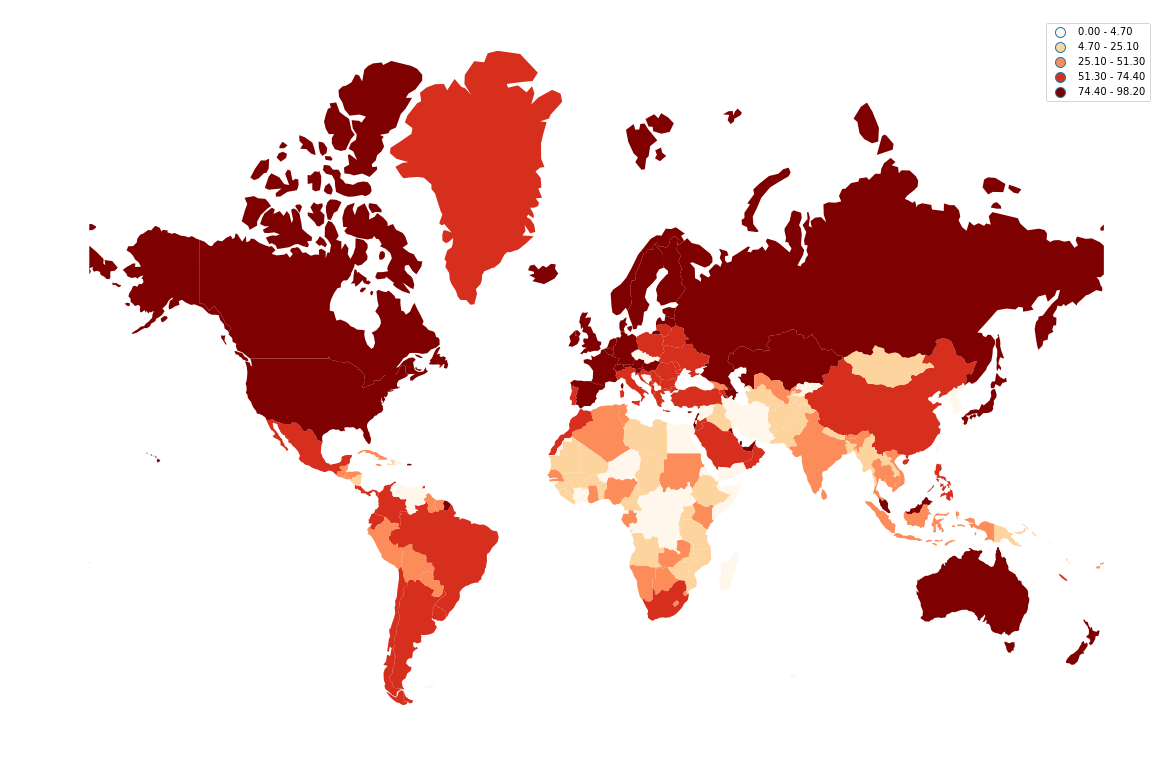

In [14]:
# mercator projection
worldMercator = world.to_crs(mercator)
worldMercator.plot(figsize=(20,20), column='internet_use', cmap="OrRd", scheme="QUANTILES", k=5, legend=True)
plt.axis('off')
plt.show()

### PySAL

In [15]:
import pysal
help(pysal)

Help on package pysal:

NAME
    pysal

DESCRIPTION
    Python Spatial Analysis Library
    
    
    Documentation
    -------------
    PySAL documentation is available in two forms: python docstrings and an html         webpage at http://pysal.org/
    
    Available sub-packages
    ----------------------
    
    cg
        Basic data structures and tools for Computational Geometry
    core
        Basic functions used by several sub-packages
    esda
        Tools for Exploratory Spatial Data Analysis
    examples
        Example data sets used by several sub-packages for examples and testing
    network
        Spatial analysis on networks
    region
        Regionalization algorithms and spatially constrained clustering
    spatial_dynamics
        Space-time exploratory methods and clustering
    spreg
        Spatial regression and econometrics
    weights
        Tools for creating and manipulating weights
    contrib
        Package for interfacing with third-party librarie

### References

Folium choropleth: http://python-visualization.github.io/folium/quickstart.html#Choropleth-maps

World bank data: https://data.worldbank.org/data-catalog/country-profiles